In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import torch
import pandas as pd
import torchmetrics

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

In [6]:
data = pd.read_csv("../data/pod_metrics.csv")
data

,timestamp,adservice-cpu,cartservice-cpu,checkoutservice-cpu,currencyservice-cpu,emailservice-cpu,frontend-cpu,paymentservice-cpu,productcatalogservice-cpu,recommendationservice-cpu,...,cartservice-mem,checkoutservice-mem,currencyservice-mem,emailservice-mem,frontend-mem,paymentservice-mem,productcatalogservice-mem,recommendationservice-mem,redis-cart-mem,shippingservice-mem
0,1708456108,3.383642,-1.493929,-2.631928,0.276536,-1.598803,-1.474558,0.014957,-1.384492,-2.536159,...,0.163339,-2.550304,-0.469397,-0.628700,-2.644476,-0.766654,0.197473,-0.858400,-1.523357,-1.157984
1,1708457008,2.812013,-1.350282,-2.508856,0.270961,-1.600751,-1.507287,0.155887,-1.290226,-2.443708,...,0.360831,-2.472679,-0.379738,-0.196058,-2.792083,-0.997823,0.211065,-0.691811,-1.821324,-0.858858
2,1708457908,2.999944,-1.177124,-2.228506,0.287442,-1.623636,-1.328903,0.311989,-1.085185,-2.317052,...,0.163879,-2.883654,-0.334065,-0.631226,-2.800478,-1.249161,0.576403,-0.616997,-2.075416,-0.684077
3,1708458808,1.866858,-1.108361,-1.720476,0.276251,-1.616145,-1.343627,0.723099,-1.056681,-2.277628,...,0.375604,-2.981764,-0.462128,-0.536559,-2.989324,-0.930879,0.547663,-0.609427,-1.842448,-1.092430
4,1708459708,1.635069,-1.079276,-1.537058,0.343738,-1.763122,-1.487650,0.757663,-1.248081,-2.407008,...,0.508510,-2.973371,-0.533949,-0.940971,-3.309007,-0.172020,0.371443,-0.298279,-1.729079,-1.093402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,1709057308,2.836190,2.018816,3.021154,0.509816,1.534967,1.275836,3.298177,1.241168,1.666614,...,0.237810,1.292374,1.712192,0.336185,0.145366,-1.359302,0.779415,1.520291,2.330827,2.250827
669,1709058208,3.628176,2.302658,3.595954,0.511928,1.795071,1.412941,4.703594,1.426781,1.748709,...,0.314156,0.893921,1.709760,0.721810,-0.150356,-1.493159,0.465832,1.711577,2.866519,1.988436
670,1709059108,2.792971,0.902710,2.913333,0.273637,1.848722,-0.316764,3.848837,-0.234245,0.759073,...,0.216902,1.618458,1.419389,0.609103,-0.418774,-2.010552,-0.538682,1.861359,3.072552,1.717014
671,1709060008,2.119125,-0.561945,2.068924,0.036087,1.852194,-1.911679,2.961966,-1.675223,-0.040916,...,-0.141541,1.196168,1.183347,0.140343,-1.425646,-2.133154,-0.682319,1.455614,2.081125,1.442000


In [7]:
data["group"] = 0
data["time_idx"] = data["timestamp"].argsort()
data.describe()

,timestamp,adservice-cpu,cartservice-cpu,checkoutservice-cpu,currencyservice-cpu,emailservice-cpu,frontend-cpu,paymentservice-cpu,productcatalogservice-cpu,recommendationservice-cpu,...,currencyservice-mem,emailservice-mem,frontend-mem,paymentservice-mem,productcatalogservice-mem,recommendationservice-mem,redis-cart-mem,shippingservice-mem,group,time_idx
count,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,...,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,673.0,673.00000
mean,1.708759e+09,3.579108e-15,8.446273e-15,-2.533882e-15,-3.167352e-17,2.111568e-15,-2.871733e-15,-1.146582e-14,2.322725e-15,-2.576113e-15,...,-6.334705e-16,1.488656e-15,5.490078e-16,2.491651e-15,8.446273e-17,-1.478098e-16,-2.005990e-15,-5.490078e-16,0.0,336.00000
std,1.749804e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,194.42265
min,1.708456e+09,-4.702707e+00,-6.388473e+00,-3.821350e+00,-3.059352e+00,-2.392999e+00,-6.613963e+00,-4.478323e+00,-6.348822e+00,-3.111000e+00,...,-1.801979e+00,-2.395920e+00,-3.309007e+00,-2.506617e+00,-3.854872e+00,-2.556886e+00,-2.716882e+00,-1.904947e+00,0.0,0.00000
25%,1.708607e+09,-4.012093e-01,-2.192032e-01,-6.088798e-01,3.310753e-01,-7.253663e-01,-2.409131e-01,-5.245137e-01,-2.590941e-01,-4.049739e-01,...,-6.187585e-01,-7.139504e-01,-6.982284e-01,-5.707704e-01,-6.165209e-01,-6.622028e-01,-6.207812e-01,-7.460573e-01,0.0,168.00000
50%,1.708759e+09,1.680988e-02,1.681962e-01,2.130850e-02,3.725491e-01,2.599504e-01,1.527618e-01,-1.894448e-02,1.132316e-01,3.946796e-01,...,-8.526231e-02,-3.568665e-02,1.370727e-01,1.579479e-01,6.338491e-02,-1.137533e-01,-2.573424e-02,-2.850018e-01,0.0,336.00000
75%,1.708910e+09,4.195061e-01,4.940261e-01,5.967731e-01,4.069983e-01,8.559265e-01,5.242088e-01,5.421197e-01,4.689786e-01,6.807381e-01,...,4.511746e-01,6.958517e-01,7.645623e-01,6.712428e-01,5.986518e-01,6.154822e-01,6.843995e-01,6.303573e-01,0.0,504.00000
max,1.709061e+09,3.628176e+00,2.332478e+00,4.014140e+00,5.546592e-01,1.852194e+00,1.578623e+00,4.703594e+00,2.488093e+00,1.864418e+00,...,3.944644e+00,4.094796e+00,1.985486e+00,2.572823e+00,2.723084e+00,2.796035e+00,3.072552e+00,2.568735e+00,0.0,672.00000


In [8]:
cutting_point = int(len(data) * 0.8)
max_encoder_length = 12
targets = list(data.columns.values)
targets.remove("timestamp")
targets.remove("group")
targets.remove("time_idx")

training = TimeSeriesDataSet(
    data.iloc[:cutting_point],
    time_idx="time_idx",
    target=targets,
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=1,
    static_reals=["group"],
    time_varying_known_reals=["timestamp", "time_idx"],
    time_varying_unknown_reals=targets,
    # target_normalizer=MultiNormalizer(
    #     [EncoderNormalizer(
    #         method='standard',
    #         center=True,
    #         max_length=None,
    #         transformation=None,
    #         method_kwargs={})
    #     ] * len(targets)
    # ),
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

## Baseline model

In [9]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
# MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [10]:
mae = torchmetrics.regression.MeanAbsoluteError().to("cuda")
mape = torchmetrics.regression.MeanAbsolutePercentageError().to("cuda")
mse = torchmetrics.regression.MeanSquaredError().to("cuda")

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [11]:
baseline_mae = mae(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))
baseline_mape = mape(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))
baseline_mse = mse(torch.cat(baseline_predictions.output), torch.cat(baseline_predictions.y[0]))

NameError: name 'mae' is not defined

## Temporal Fusion Transformer

In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cuda",
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 35.4k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.2454708915685031
Restoring states from the checkpoint path at /home/jlcg/projects/pod-resource-prediction/notebooks/.lr_find_3f98b2d1-ec6e-4712-9ffb-6b104edf998a.ckpt
Restored all states from the checkpoint at /home/jlcg/projects/pod-resource-prediction/notebooks/.lr_find_3f98b2d1-ec6e-4712-9ffb-6b104edf998a.ckpt


suggested learning rate: 0.2454708915685031


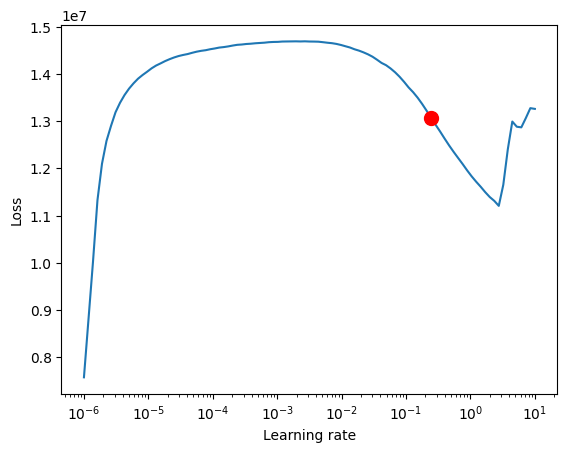

In [9]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [10]:
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [11]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 68.4k


In [12]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 1.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 32.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 17.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [62]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
torch.save(best_tft.state_dict(), "../models/transformer.pt")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
best_tft.load_state_dict(torch.load("../models/transformer.pt"))
best_tft.to("cuda")

TemporalFusionTransformer(
  	"attention_head_size":               2
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            8
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       16
  	"learning_rate":                     0.2
  	"log_gradient_flow":                 False
  	"log_interval":                      10
  	"log_val_interval":                  10
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              MultiLoss(QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]), QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98

In [20]:
tft_predictions = best_tft.predict(val_dataloader, return_y=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [21]:
tft_mae = mae(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))
tft_mape = mape(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))
tft_mse = mse(torch.cat(tft_predictions.output), torch.cat(tft_predictions.y[0]))

In [26]:
tft_mae / baseline_mae, tft_mape / baseline_mape, tft_mse / baseline_mse 

(tensor(0.8445, device='cuda:0'),
 tensor(0.9326, device='cuda:0'),
 tensor(0.6030, device='cuda:0'))

## LSTM

In [29]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

lstm = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM"
)
print(f"Number of parameters in network: {lstm.size()/1e3:.1f}k")

Number of parameters in network: 4.4k


In [30]:
trainer.fit(
    lstm,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MultiLoss      | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 4.2 K 
4 | output_projector | ModuleList     | 242   
----------------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [31]:
best_lstm_path = trainer.checkpoint_callback.best_model_path
best_lstm = RecurrentNetwork.load_from_checkpoint(best_lstm_path)
torch.save(best_lstm.state_dict(), "../models/lstm.pt")

In [32]:
lstm_predictions = best_lstm.predict(val_dataloader, return_y=True)

lstm_mae = mae(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))
lstm_mape = mape(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))
lstm_mse = mse(torch.cat(lstm_predictions.output), torch.cat(lstm_predictions.y[0]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [33]:
lstm_mae / baseline_mae, lstm_mape / baseline_mape, lstm_mse / baseline_mse 

(tensor(0.8404, device='cuda:0'),
 tensor(0.9311, device='cuda:0'),
 tensor(0.5884, device='cuda:0'))

## GRU

In [34]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

gru = RecurrentNetwork.from_dataset(
    training,
    cell_type="GRU"
)
print(f"Number of parameters in network: {gru.size()/1e3:.1f}k")

Number of parameters in network: 3.4k


In [35]:
trainer.fit(
    gru,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MultiLoss      | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | GRU            | 3.1 K 
4 | output_projector | ModuleList     | 242   
----------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [36]:
best_gru_path = trainer.checkpoint_callback.best_model_path
best_gru = RecurrentNetwork.load_from_checkpoint(best_gru_path)
torch.save(best_gru.state_dict(), "../models/gru.pt")

In [37]:
gru_predictions = best_gru.predict(val_dataloader, return_y=True)

gru_mae = mae(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))
gru_mape = mape(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))
gru_mse = mse(torch.cat(gru_predictions.output), torch.cat(gru_predictions.y[0]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [38]:
gru_mae / baseline_mae, gru_mape / baseline_mape, gru_mse / baseline_mse 

(tensor(0.8480, device='cuda:0'),
 tensor(0.9148, device='cuda:0'),
 tensor(0.6004, device='cuda:0'))